In [1]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

## Image Augmentation

In [2]:
url = "dataset-out"

train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   rescale=1./255,
                                   )

test_datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 64
img_size = (128, 128)

train_set = train_datagen.flow_from_directory(url + '/train', 
                                              class_mode='sparse',
                                              batch_size = batch_size,
                                              target_size=img_size,)

val_set = test_datagen.flow_from_directory(url + '/val',
                                           class_mode='sparse',
                                           batch_size = batch_size,
                                           target_size=img_size,)

test_set = test_datagen.flow_from_directory(url + '/test',
                                            class_mode='sparse',
                                           batch_size = batch_size,
                                           shuffle=False,
                                           target_size=img_size)

Found 2219 images belonging to 7 classes.
Found 276 images belonging to 7 classes.
Found 283 images belonging to 7 classes.


In [3]:
class_to_index = train_set.class_indices
index_to_class = {v: k for k, v in class_to_index.items()}

print(class_to_index)
print(index_to_class)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'organic': 3, 'paper': 4, 'plastic': 5, 'trash': 6}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'organic', 4: 'paper', 5: 'plastic', 6: 'trash'}


## Base Model

In [ ]:
model1 = keras.models.Sequential([
    keras.layers.Input(shape=(128,128,3)),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(padding='same'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(padding='same'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(padding='same'),
    keras.layers.BatchNormalization(),

    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(7, activation='softmax'),
])

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model1.summary()

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=2)
checkpoint = keras.callbacks.ModelCheckpoint('my_model', save_best_only=True)

hist = model1.fit(train_set, validation_data=val_set, epochs=20, callbacks=[early_stopping, checkpoint])

## Transfer Learning with MobileNetV2

In [4]:
baseModel = keras.applications.MobileNetV2(input_shape=(128, 128, 3), weights='imagenet',
                                           include_top=False)

for layers in baseModel.layers:
    layers.trainable=False

In [7]:
model = keras.models.Sequential([
    baseModel,
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(7, activation='softmax'),
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])

epochs=50
callbacks = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dropout_2 (Dropout)         (None, 20480)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               2621568   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 903       
                                                      

In [8]:
history = model.fit(train_set, validation_data=val_set, epochs=epochs, callbacks=[callbacks])

Epoch 1/50
35/35 [==============================] - 22s 554ms/step - loss: 2.4869 - accuracy: 0.4804 - val_loss: 0.8364 - val_accuracy: 0.7101
Epoch 2/50
35/35 [==============================] - 19s 527ms/step - loss: 0.9401 - accuracy: 0.6575 - val_loss: 0.7640 - val_accuracy: 0.7500
Epoch 3/50
35/35 [==============================] - 18s 527ms/step - loss: 0.8204 - accuracy: 0.7026 - val_loss: 0.7115 - val_accuracy: 0.7790
Epoch 4/50
35/35 [==============================] - 18s 525ms/step - loss: 0.7526 - accuracy: 0.7319 - val_loss: 0.6753 - val_accuracy: 0.7572
Epoch 5/50
35/35 [==============================] - 19s 527ms/step - loss: 0.7411 - accuracy: 0.7328 - val_loss: 0.6832 - val_accuracy: 0.7717
Epoch 6/50
35/35 [==============================] - 18s 525ms/step - loss: 0.6607 - accuracy: 0.7607 - val_loss: 0.6962 - val_accuracy: 0.7681
Epoch 7/50
35/35 [==============================] - 18s 524ms/step - loss: 0.6458 - accuracy: 0.7607 - val_loss: 0.6733 - val_accuracy: 0.8152

#### Training process evaluating

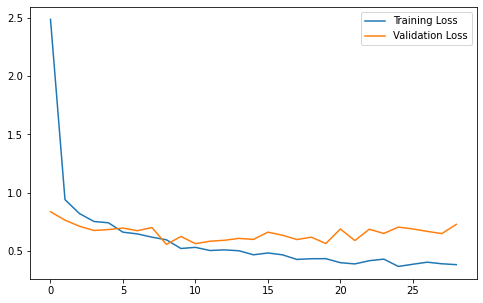

In [9]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])

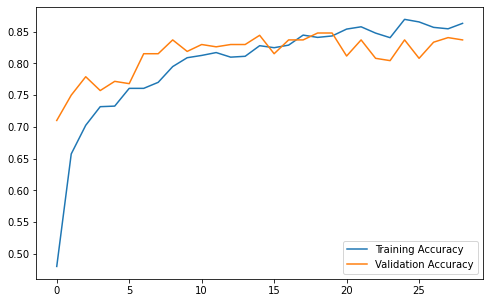

In [10]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])

## Validation Test

In [19]:
train_set = test_datagen.flow_from_directory(url + '/train',
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            target_size=img_size)

val_set = test_datagen.flow_from_directory(url + '/val',
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            target_size=img_size)

Found 2219 images belonging to 7 classes.
Found 276 images belonging to 7 classes.


### Train Loss vs Validation Loss

In [20]:
print("Training loss - Accuracy")
model.evaluate(train_set)
print("Validation loss - Accuracy")
model.evaluate(val_set)
print()

Training loss - Accuracy
35/35 [==============================] - 12s 353ms/step - loss: 0.2695 - accuracy: 0.9036
Validation loss - Accuracy
5/5 [==============================] - 2s 290ms/step - loss: 0.6177 - accuracy: 0.8478



### Precision, Recall, F1-score, and Confusion Matrix

In [13]:
target_names = list(test_set.class_indices.keys())

def evaluate(y, y_pred):
    fig, ax = plt.subplots(figsize=(10, 10))

    cm = confusion_matrix(y, y_pred)

    cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    
    cmp.plot(ax=ax, cmap='Blues')
    fig.show()

    print(classification_report(y, y_pred, digits=5, target_names=target_names))

#### Train set

35/35 [==============================] - 13s 355ms/step
              precision    recall  f1-score   support

   cardboard    0.94154   0.95031   0.94590       322
       glass    0.87990   0.89750   0.88861       400
       metal    0.84211   0.97561   0.90395       328
     organic    0.97059   0.99000   0.98020       200
       paper    0.88304   0.95368   0.91700       475
     plastic    0.97667   0.76104   0.85547       385
       trash    0.85393   0.69725   0.76768       109

    accuracy                        0.90356      2219
   macro avg    0.90682   0.88934   0.89412      2219
weighted avg    0.90762   0.90356   0.90184      2219



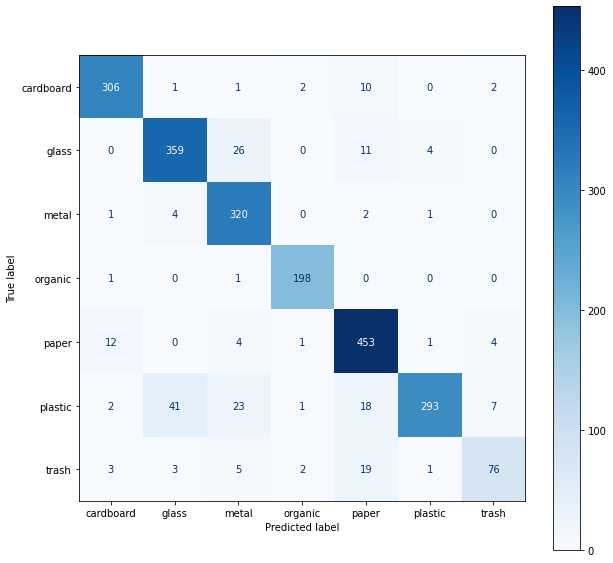

In [14]:
y = train_set.labels
y_pred = np.argmax(model.predict(train_set), axis=1)
evaluate(y, y_pred)

#### Validation set

5/5 [==============================] - 2s 345ms/step
              precision    recall  f1-score   support

   cardboard    0.90000   0.90000   0.90000        40
       glass    0.75000   0.90000   0.81818        50
       metal    0.81395   0.85366   0.83333        41
     organic    1.00000   1.00000   1.00000        25
       paper    0.81538   0.89831   0.85484        59
     plastic    1.00000   0.66667   0.80000        48
       trash    0.72727   0.61538   0.66667        13

    accuracy                        0.84783       276
   macro avg    0.85809   0.83343   0.83900       276
weighted avg    0.86027   0.84783   0.84630       276



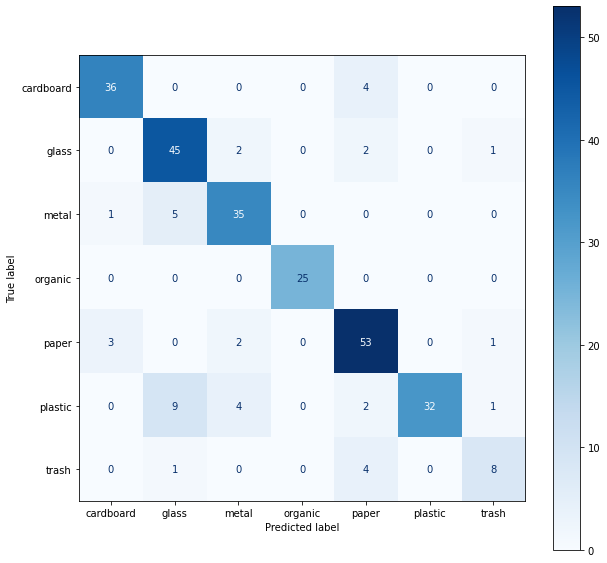

In [21]:
y = val_set.labels
y_pred = np.argmax(model.predict(val_set), axis=1)
evaluate(y, y_pred)

## Final Evaluation on Test set

### Classification Report and Confusion Matrix

5/5 [==============================] - 2s 334ms/step
              precision    recall  f1-score   support

   cardboard    0.97297   0.87805   0.92308        41
       glass    0.86792   0.90196   0.88462        51
       metal    0.84444   0.92683   0.88372        41
     organic    0.83871   1.00000   0.91228        26
       paper    0.79104   0.88333   0.83465        60
     plastic    0.96774   0.61224   0.75000        49
       trash    0.47368   0.60000   0.52941        15

    accuracy                        0.84099       283
   macro avg    0.82236   0.82892   0.81682       283
weighted avg    0.85714   0.84099   0.83987       283



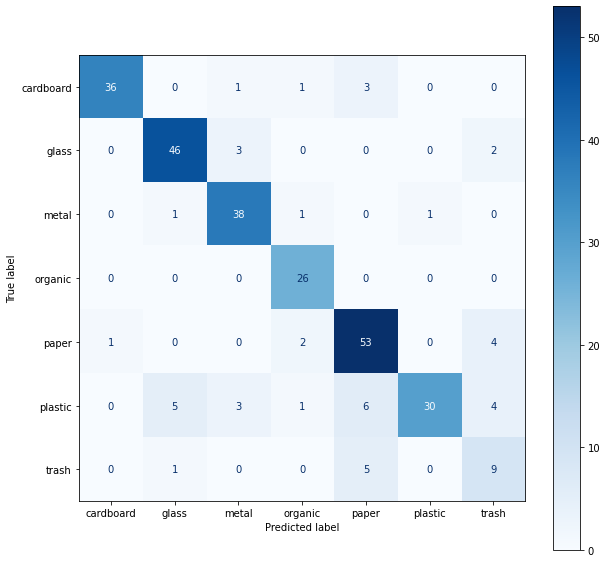

In [22]:
y = test_set.labels
y_pred = np.argmax(model.predict(test_set), axis=1)
evaluate(y, y_pred)

### Random Sample Test

In [23]:
def test():
    batch = np.random.randint(0, len(test_set)-1)
    data = 0
    img = np.random.randint(0, len(test_set[batch][data])-1)
    IMAG = test_set[batch][data][img]

    plt.imshow(IMAG)
    plt.show()
    pred = model.predict(IMAG.reshape(1, 128, 128, 3))
    probability = pred.max()
    index = np.argmax(pred)
    label = index_to_class.get(index)
    print(f"Model predicts {label.capitalize()} with probability {probability}")
    

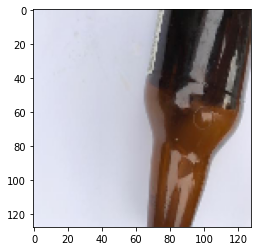

1/1 [==============================] - 0s 42ms/step
Model predicts Glass with probability 0.9824222922325134


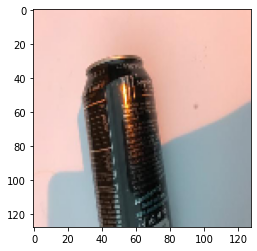

1/1 [==============================] - 0s 33ms/step
Model predicts Metal with probability 0.9878609776496887


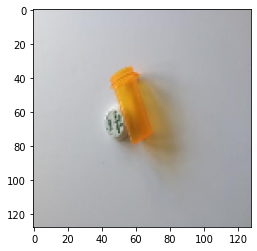

1/1 [==============================] - 0s 33ms/step
Model predicts Plastic with probability 0.7268586158752441


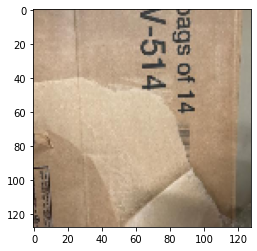

1/1 [==============================] - 0s 32ms/step
Model predicts Cardboard with probability 0.9999963045120239


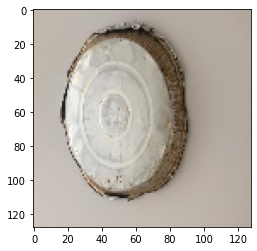

1/1 [==============================] - 0s 34ms/step
Model predicts Metal with probability 0.43756651878356934


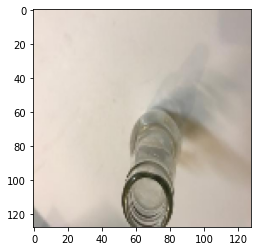

1/1 [==============================] - 0s 33ms/step
Model predicts Glass with probability 0.9315439462661743


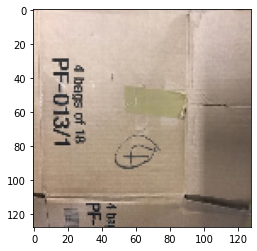

1/1 [==============================] - 0s 33ms/step
Model predicts Cardboard with probability 0.9999967813491821


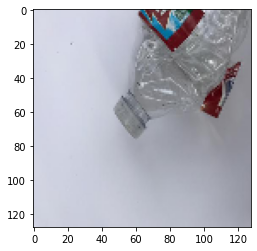

1/1 [==============================] - 0s 35ms/step
Model predicts Trash with probability 0.32602542638778687


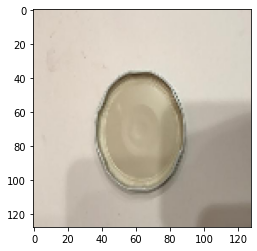

1/1 [==============================] - 0s 41ms/step
Model predicts Metal with probability 0.9066293239593506


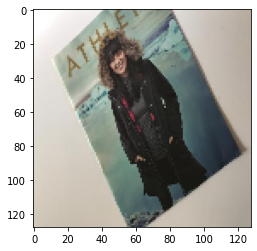

1/1 [==============================] - 0s 32ms/step
Model predicts Paper with probability 0.9870057106018066


In [25]:
for i in range(10):
    test()

## Save model

In [26]:
model.save("waste_classifier_v2")

INFO:tensorflow:Assets written to: waste_classifier_v2\assets


INFO:tensorflow:Assets written to: waste_classifier_v2\assets
